In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
def to_homogeneous(coordinates):
    """
    Convert 2D coordinates to homogeneous coordinates.
    
    Args:
        coordinates (numpy.ndarray): Array of 2D coordinates of shape (N, 2).
    
    Returns:
        numpy.ndarray: Array of homogeneous coordinates of shape (N, 3).
    """
    # Check if the input array is a NumPy array
    if not isinstance(coordinates, np.ndarray):
        raise ValueError("Input must be a NumPy array")
    
    # Check if the input array has the correct shape
    if coordinates.shape[1] != 2:
        raise ValueError("Input array must have shape (N, 2)")
    
    # Add a column of ones to the coordinates to make them homogeneous
    homogeneous_coordinates = np.hstack((coordinates, np.ones((coordinates.shape[0], 1))))
    
    return homogeneous_coordinates

In [3]:
img1 = cv.imread('.././data/images/left1.jpg', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('.././data/images/right1.jpg', cv.IMREAD_GRAYSCALE) 
 
sift = cv.SIFT_create() 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# Create BFMatcher (Brute Force Matcher)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

pts1 = []
pts2 = [] 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
 if m.distance < 0.8*n.distance:
     pts1.append(kp1[m.queryIdx].pt)
     pts2.append(kp2[m.trainIdx].pt)

In [4]:
# Finding Fundamental matrix
pts1_ = np.array(pts1)
pts2_ = np.array(pts2)
F, mask = cv.findFundamentalMat(pts1_, pts2_, cv.RANSAC)

# We select only inlier points
pts1_ = pts1_[mask.ravel()==1]
pts2_ = pts2_[mask.ravel()==1]

array([[111.77406311,  23.88624382],
       [119.79264069,  45.74068451],
       [124.49798584,  38.40169144],
       [127.65912628,  35.01478195],
       [142.26486206,  38.67093277],
       [205.35939026, 265.14346313],
       [225.99435425, 186.22814941],
       [226.85029602, 187.87635803],
       [226.85029602, 187.87635803],
       [244.74290466, 288.79598999],
       [245.33554077, 305.14492798],
       [350.01431274, 288.8885498 ],
       [445.15106201, 218.53942871],
       [495.29425049, 272.53442383]])

### Compute the Epipolar 
#cv.computeCorrespondEpilines

To find two points on the epipolar line that lie on the image boundary, we can exploit the equation of the line, which is obtained by multiplying a point in one image by the fundamental matrix. The equation of the line is given by:

$ l = F \cdot p $

Where:
- $ l $ is the equation of the epipolar line.
- $F $ is the fundamental matrix.
- $p$ is a point in one image.

The equation of a line in 2D can be represented as:

$ ax + by + c = 0$

So, for the epipolar line, \( l \), we have:

$ ax + by + c = 0 $

Given a line in this form, we can find two points on this line that lie on the image boundary by setting one of the coordinates to either 0 or the width/height of the image (depending on which boundary we want to intersect). Then, we solve for the other coordinate.


1. **Point on the Left Boundary**: To find a point on the left boundary (x = 0), we set \( x = 0 \) in the equation of the line \( ax + by + c = 0 \) and solve for \( y \). This gives us the coordinates of the point (0, \( y_0 \)).

2. **Point on the Right Boundary**: Similarly, to find a point on the right boundary (x = image width), we set \( x = \text{image width} \) in the equation of the line \( ax + by + c = 0 \) and solve for \( y \). This gives us the coordinates of the point (\( \text{image width} \), \( y_1 \)).

Once we have these two points, we can draw a line segment connecting them, which represents the epipolar line on the image.

In Python code, this process is implemented as follows:

```python
# Find a point on the left boundary (x = 0)
y0 = -c / b

# Find a point on the right boundary (x = image.shape[1])
y1 = (-c - a * image.shape[1]) / b
```

These points (0, \( y_0 \)) and (\( width \), \( y_1 \)) are the two points on the epipolar line that lie on the image boundary.

In [9]:
# TODO
l=to_homogeneous(pts2_).dot(F)[0]
l

array([ 4.62934955e-04,  3.08720670e-02, -7.89161842e-01])

In [10]:
y0=-l[-1]/l[1]
y1=(-l[-1]-l[0]*img1.shape[1])/l[1]


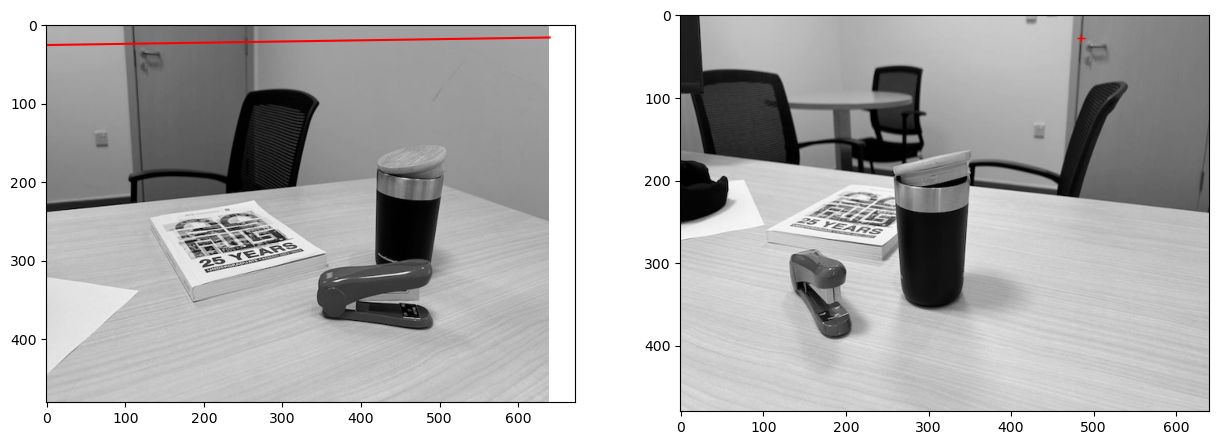

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(img1,cmap='gray')
plt.plot([0,img1.shape[1]],[y0,y1],'r')

plt.subplot(122)
plt.imshow(img2,cmap='gray')
plt.plot(pts2_[0,0],pts2_[0,1],'r+')
plt.show()